In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import import_ipynb
from helpers import train_and_validate, count_parameters, plot_loss_comparison, plot_test_predictions, compare_mse_loss
import time
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

importing Jupyter notebook from helpers.ipynb


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
window_size = 24
batch_size = 100
input_size = 1
hidden_size = 100
num_classes = 1
learning_rate = 0.001
epochs = 100
criterion = nn.MSELoss()

In [4]:
def root_mean_squared_error(actual, predicted):
    actual = torch.tensor(actual, dtype=torch.float32)
    predicted = torch.tensor(predicted, dtype=torch.float32)
    
    if actual.shape != predicted.shape:
        raise ValueError("Tensors must have the same shape.")
    
    mse = torch.mean((actual - predicted)**2)
    
    return (mse.item() ** 0.5)

In [5]:
df = pd.read_csv("../data/clean_woodland_data.csv")
df = df[:-24]
df.shape

(25623, 2)

In [6]:
df = df[["Date", "P (kW)"]]
train_df = df.iloc[:-24]
test = df.iloc[-24:]

In [7]:
def prepare_dataframe(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'P (kW)(t-{i})'] = df['P (kW)'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

In [8]:
new_df = prepare_dataframe(train_df, window_size)
new_df = new_df.to_numpy()
new_df

array([[0.        , 0.        , 0.        , ..., 2.7620833 , 0.4105833 ,
        0.        ],
       [0.7431667 , 0.        , 0.        , ..., 5.46125   , 2.7620833 ,
        0.4105833 ],
       [4.3818335 , 0.7431667 , 0.        , ..., 8.356167  , 5.46125   ,
        2.7620833 ],
       ...,
       [0.2003    , 2.5545    , 7.135     , ..., 0.04238092, 0.04661901,
        0.0508571 ],
       [0.10015   , 0.2003    , 2.5545    , ..., 0.03814282, 0.04238092,
        0.04661901],
       [0.        , 0.10015   , 0.2003    , ..., 0.03390473, 0.03814282,
        0.04238092]])

In [9]:
new_df.shape

(25575, 25)

In [10]:
X = new_df[:, 1:]
y = new_df[:, 0]

In [11]:
X.shape, y.shape

((25575, 24), (25575,))

In [12]:
split_index = int(len(X) * 0.9)

In [13]:
X_train = X[:split_index]
X_val = X[split_index:]

y_train = y[:split_index]
y_val = y[split_index:]

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((23017, 24), (2558, 24), (23017,), (2558,))

In [14]:
X_train = X_train.reshape((-1, window_size, 1))
X_val = X_val.reshape((-1, window_size, 1))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((23017, 24, 1), (2558, 24, 1), (23017, 1), (2558, 1))

In [15]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()

X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([23017, 24, 1]),
 torch.Size([2558, 24, 1]),
 torch.Size([23017, 1]),
 torch.Size([2558, 1]))

In [16]:
class SolarData(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [17]:
train = SolarData(X_train, y_train)
val = SolarData(X_val, y_val)

In [18]:
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val, batch_size = batch_size, shuffle = False)

In [19]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([100, 24, 1]) torch.Size([100, 1])


## RNN

In [20]:
class RNNNet(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.rnn_layer = nn.RNN(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, hidden = self.rnn_layer(x)
        out = self.fc(out[:, -1, :])
        return out

In [21]:
rnnnet = RNNNet(input_size, hidden_size, num_classes).to(device)
rnnnet_optimizer = torch.optim.Adam(rnnnet.parameters(), lr = learning_rate)

In [22]:
total_rnnnet_parameters = count_parameters(rnnnet)

In [23]:
rnnnet_train_loss_array = []
rnnnet_val_loss_array = []

In [24]:
rnnnet_start_time = time.time()
train_and_validate(epochs, device, rnnnet, train_loader, val_loader, criterion, rnnnet_optimizer, rnnnet_train_loss_array, rnnnet_val_loss_array)
rnnnet_end_time = time.time()
rnnnet_total_training_time = rnnnet_end_time - rnnnet_start_time
rnnnet_avg_training_time_per_epoch = rnnnet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 6.619718195556046 | Validation Loss: 2.675650524118772
Epoch no.: 2 | Training Loss: 3.442550593640381 | Validation Loss: 2.7180733824856222
Epoch no.: 3 | Training Loss: 2.9224543973997044 | Validation Loss: 1.1191957135731803
Epoch no.: 4 | Training Loss: 2.322233512546077 | Validation Loss: 0.8048087080868964
Epoch no.: 5 | Training Loss: 1.8340091333760844 | Validation Loss: 0.55237958759356
Epoch no.: 6 | Training Loss: 1.3982436783385999 | Validation Loss: 0.38399923413705367
Epoch no.: 7 | Training Loss: 1.2558878741481088 | Validation Loss: 0.3258616308538386
Epoch no.: 8 | Training Loss: 1.1472997631861535 | Validation Loss: 0.4228289802200519
Epoch no.: 9 | Training Loss: 1.1355290473539592 | Validation Loss: 0.25606658301638585
Epoch no.: 10 | Training Loss: 1.0786294413335396 | Validation Loss: 0.16747593256429985
Epoch no.: 11 | Training Loss: 1.031509680084852 | Validation Loss: 0.18554511619731784
Epoch no.: 12 | Training Loss: 0.99623011071

In [25]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     RNN: {total_rnnnet_parameters}")
print()
print(f"Total Training Time:     RNN: {rnnnet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     RNN: {rnnnet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")



------------------------------------------------------------
Total Parameters:     RNN: 10401

Total Training Time:     RNN: 94.03s

Average Training Time Per Epoch:     RNN: 0.94s
------------------------------------------------------------


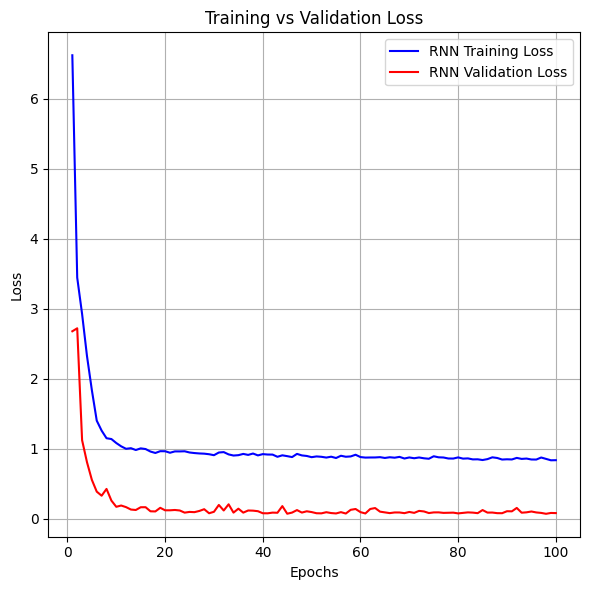

In [26]:
plot_loss_comparison(epochs, rnnnet_train_loss_array, rnnnet_val_loss_array, "RNN Training Loss", "RNN Validation Loss", "Training vs Validation Loss")

In [27]:
rnnnet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(window_size):
    # Make the prediction
    with torch.no_grad():
        pred_test = rnnnet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

C:\Users\itadmin\AppData\Local\Temp\ipykernel_11712\1549511991.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)


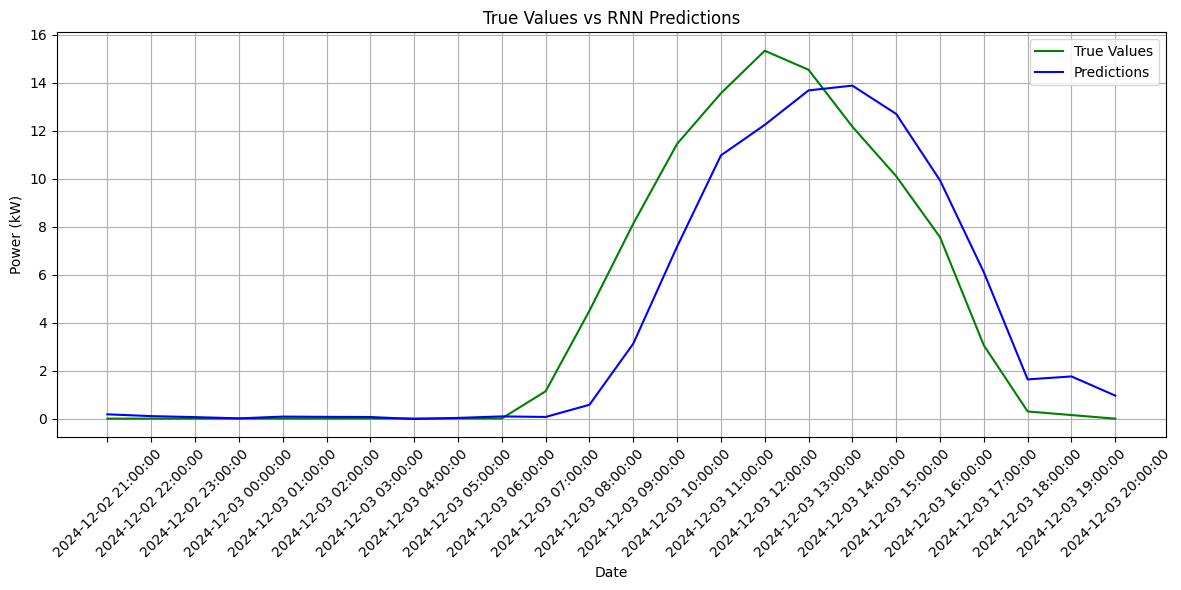

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs RNN Predictions')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
rmse = root_mean_squared_error(test["P (kW)"].values, predictions_test)
r2 = r2_score(test["P (kW)"].values, predictions_test)
print(f"Root Mean Squared Error: {rmse}")
print(f'R-squared value: {r2}')

Root Mean Squared Error: 2.1086796497488405
R-squared value: 0.8541687495562178


## LSTM

In [30]:
class LSTMNet(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x_, (h_t, c_t) = self.lstm(x)
        out = self.fc(x_[:, -1, :])
        return out

In [31]:
lstmnet = LSTMNet(input_size, hidden_size, num_classes).to(device)
lstmnet_optimizer = torch.optim.Adam(lstmnet.parameters(), lr = learning_rate)

In [32]:
total_lstmnet_parameters = count_parameters(lstmnet)

In [33]:
lstmnet_train_loss_array = []
lstmnet_val_loss_array = []

In [34]:
lstmnet_start_time = time.time()
train_and_validate(epochs, device, lstmnet, train_loader, val_loader, criterion, lstmnet_optimizer, lstmnet_train_loss_array, lstmnet_val_loss_array)
lstmnet_end_time = time.time()
lstmnet_total_training_time = lstmnet_end_time - lstmnet_start_time
lstmnet_avg_training_time_per_epoch = lstmnet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 6.2504346935780015 | Validation Loss: 0.4668656571392113
Epoch no.: 2 | Training Loss: 1.2492144294889458 | Validation Loss: 0.255170062972376
Epoch no.: 3 | Training Loss: 1.0392956318277302 | Validation Loss: 0.12519561914870372
Epoch no.: 4 | Training Loss: 0.9858504053189124 | Validation Loss: 0.1446566365705691
Epoch no.: 5 | Training Loss: 0.9740396292307676 | Validation Loss: 0.09378530570001413
Epoch no.: 6 | Training Loss: 0.9635193124736027 | Validation Loss: 0.10872561877029231
Epoch no.: 7 | Training Loss: 0.9554001963757849 | Validation Loss: 0.15071140036273462
Epoch no.: 8 | Training Loss: 0.9719005610906717 | Validation Loss: 0.1242104726485335
Epoch no.: 9 | Training Loss: 0.9088895159624356 | Validation Loss: 0.08970073643230045
Epoch no.: 10 | Training Loss: 0.9320324592260055 | Validation Loss: 0.106377989707443
Epoch no.: 11 | Training Loss: 0.8920337609398417 | Validation Loss: 0.07087130827354625
Epoch no.: 12 | Training Loss: 0.8922

In [35]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     LSTM: {total_lstmnet_parameters}")
print()
print(f"Total Training Time:     LSTM: {lstmnet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     LSTM: {lstmnet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")



------------------------------------------------------------
Total Parameters:     LSTM: 41301

Total Training Time:     LSTM: 132.34s

Average Training Time Per Epoch:     LSTM: 1.32s
------------------------------------------------------------


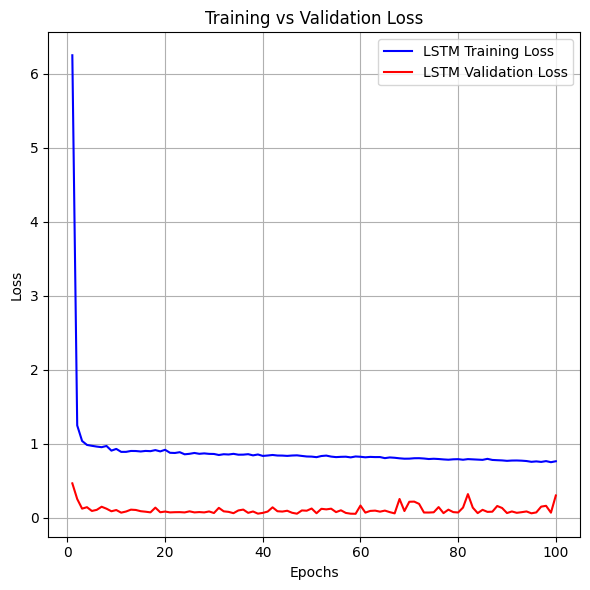

In [36]:
plot_loss_comparison(epochs, lstmnet_train_loss_array, lstmnet_val_loss_array, "LSTM Training Loss", "LSTM Validation Loss", "Training vs Validation Loss")

In [37]:
lstmnet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(window_size):
    # Make the prediction
    with torch.no_grad():
        pred_test = lstmnet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

C:\Users\itadmin\AppData\Local\Temp\ipykernel_11712\22171312.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)


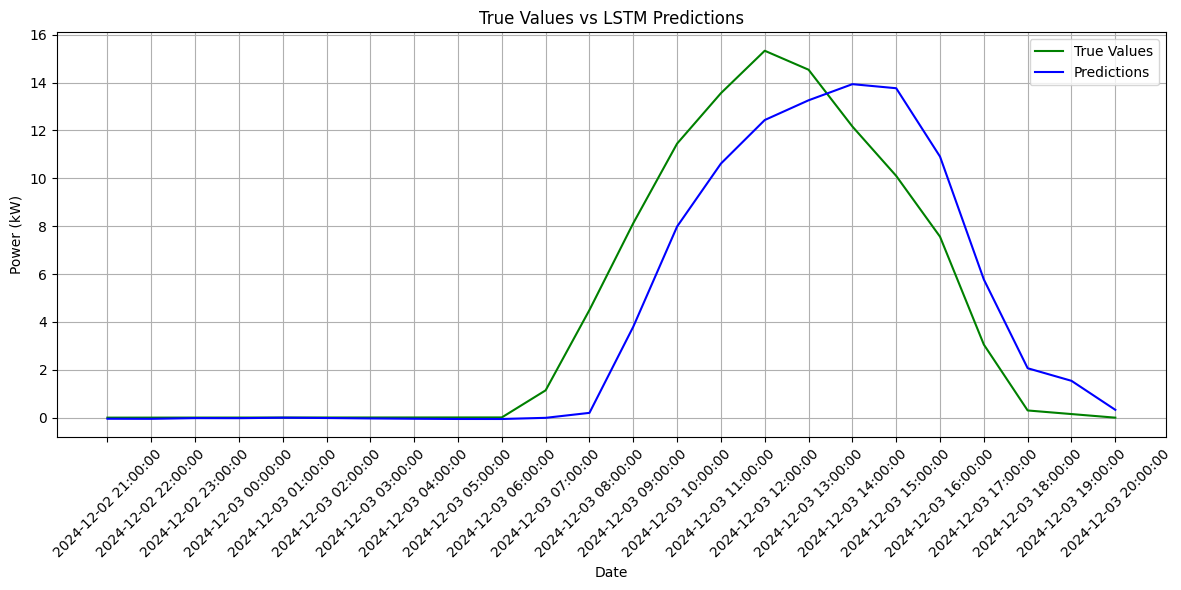

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
rmse = root_mean_squared_error(test["P (kW)"].values, predictions_test)
r2 = r2_score(test["P (kW)"].values, predictions_test)
print(f"Root Mean Squared Error: {rmse}")
print(f'R-squared value: {r2}')

Root Mean Squared Error: 2.1358208870745266
R-squared value: 0.8503905319418932


## GRU 

In [50]:
class GRUNet(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, num_classes: int):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.gru = nn.GRU(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x_, h = self.gru(x)
        out = self.fc(x_[:, -1, :])
        return out

In [51]:
grunet = LSTMNet(input_size, hidden_size, num_classes).to(device)
grunet_optimizer = torch.optim.Adam(grunet.parameters(), lr = learning_rate)

In [52]:
total_grunet_parameters = count_parameters(grunet)

In [53]:
grunet_train_loss_array = []
grunet_val_loss_array = []

In [54]:
grunet_start_time = time.time()
train_and_validate(epochs, device, grunet, train_loader, val_loader, criterion, grunet_optimizer, grunet_train_loss_array, grunet_val_loss_array)
grunet_end_time = time.time()
grunet_total_training_time = grunet_end_time - grunet_start_time
grunet_avg_training_time_per_epoch = grunet_total_training_time / epochs

Epoch no.: 1 | Training Loss: 6.854061985428715 | Validation Loss: 1.267013888659746
Epoch no.: 2 | Training Loss: 1.700703541179756 | Validation Loss: 0.24016947517744625
Epoch no.: 3 | Training Loss: 1.1470419196855455 | Validation Loss: 0.15351282002834174
Epoch no.: 4 | Training Loss: 1.0675644865541747 | Validation Loss: 0.11685135106213587
Epoch no.: 5 | Training Loss: 1.01220291969064 | Validation Loss: 0.24471612026144823
Epoch no.: 6 | Training Loss: 0.9862777399810362 | Validation Loss: 0.26114525817907774
Epoch no.: 7 | Training Loss: 0.9716186742761951 | Validation Loss: 0.199127718161505
Epoch no.: 8 | Training Loss: 0.9809869045302981 | Validation Loss: 0.10838506308097678
Epoch no.: 9 | Training Loss: 0.9573459547835511 | Validation Loss: 0.15146455123948938
Epoch no.: 10 | Training Loss: 0.9639721080596313 | Validation Loss: 0.08788605219069723
Epoch no.: 11 | Training Loss: 0.937812463545696 | Validation Loss: 0.07366739256338825
Epoch no.: 12 | Training Loss: 0.942850

In [55]:
print()
print()
print("------------------------------------------------------------")
print(f"Total Parameters:     GRU: {total_grunet_parameters}")
print()
print(f"Total Training Time:     GRU: {grunet_total_training_time:.2f}s")
print()
print(f"Average Training Time Per Epoch:     GRU: {grunet_avg_training_time_per_epoch:.2f}s")

print("------------------------------------------------------------")



------------------------------------------------------------
Total Parameters:     GRU: 41301

Total Training Time:     GRU: 126.11s

Average Training Time Per Epoch:     GRU: 1.26s
------------------------------------------------------------


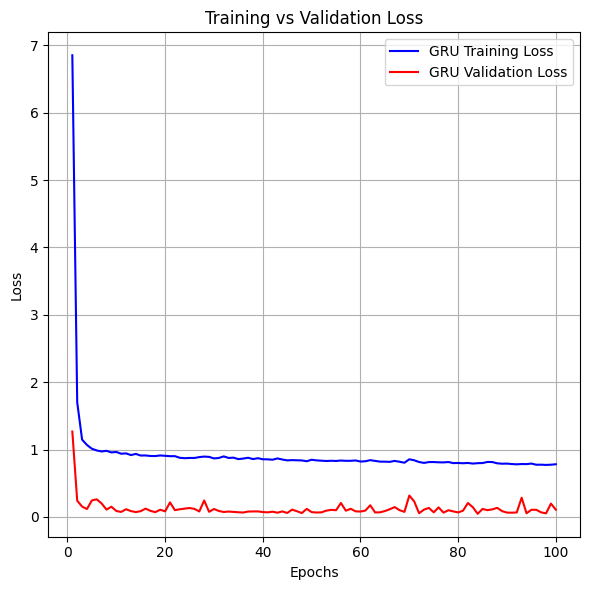

In [56]:
plot_loss_comparison(epochs, grunet_train_loss_array, grunet_val_loss_array, "GRU Training Loss", "GRU Validation Loss", "Training vs Validation Loss")

In [57]:
grunet.eval()
last_24_values_test = y_val[-window_size:]
last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)
predictions_test = []

for i in range(window_size):
    # Make the prediction
    with torch.no_grad():
        pred_test = grunet(last_24_values_test)
    
    # Store the prediction
    predictions_test.append(pred_test.item())
    
    # Shift the values to the left and add the predicted value to the last_24_values_test for the next iteration
    last_24_values_test = torch.cat((last_24_values_test[:, 1:], pred_test.unsqueeze(1)), dim=1)

# Convert predictions_test to a numpy array
predictions_test = np.array(predictions_test)

C:\Users\itadmin\AppData\Local\Temp\ipykernel_11712\1542476720.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  last_24_values_test = torch.tensor(last_24_values_test, dtype=torch.float32).unsqueeze(0).to(device)


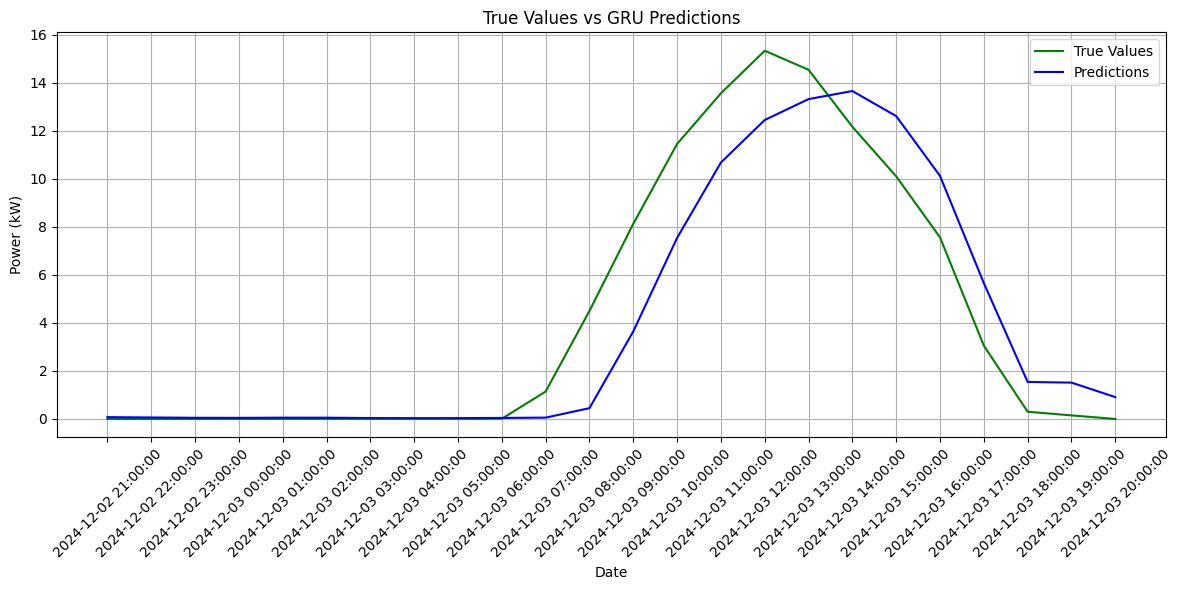

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['P (kW)'], 'g', label='True Values')
plt.plot(test['Date'], predictions_test, 'b', label='Predictions')
plt.title('True Values vs GRU Predictions')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
rmse = root_mean_squared_error(test["P (kW)"].values, predictions_test)
r2 = r2_score(test["P (kW)"].values, predictions_test)
print(f"Root Mean Squared Error: {rmse}")
print(f'R-squared value: {r2}')

Root Mean Squared Error: 2.0116026020778865
R-squared value: 0.8672868953851313
